In [ ]:
!pip install pyro-ppl

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import random
from pyro.infer import HMC, MCMC,NUTS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler


In [ ]:
df=pd.read_csv(r'/content/diabetes.csv') #import dataset

In [ ]:
df.dropna(inplace=True) #drop null values

In [ ]:
X=df.drop("Outcome",axis=1) #split between variables and target
y=df.loc[:,'Outcome']

In [ ]:
print(f"The total number of patients is {len(y)}, the number of patients which have diabetes is {y.sum()}")

The total number of patients is 768, the number of patients which have diabetes is 268


We can see that the dataset is unbalanced


In [ ]:
for column in X.columns:
    # Calculate the mean of non-zero values in the column
    mean_without_zeros = X.loc[X[column] != 0, column].mean()

    # Replace zeros with the calculated mean
    X.loc[X[column] == 0, column] = mean_without_zeros

seed = 1234
random.seed(seed)
np.random.seed(seed)
th.manual_seed(seed)

# Apply Min-Max scaling to X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
over_sampler = RandomOverSampler(random_state=1234) #balancing the data with over sampling
X, y = over_sampler.fit_resample(X,y)
X=X.to_numpy() #convert to numpy
y=y.to_numpy()

In [ ]:
kf=KFold(n_splits=5,shuffle=True)

In [ ]:
#define the model: standard logistic function with uninformative priors
def model(X,y):
  prior_mean=th.zeros(X.shape[1])
  prior_sd=th.ones(X.shape[1])
  w=pyro.sample("w",dist.Normal(prior_mean,prior_sd))

  b=pyro.sample("b",dist.Normal(0,1))

  model=dist.Bernoulli(logits=b+th.matmul(X,w))

  return pyro.sample("obs",model,obs=y)

In [ ]:
accuracies=[] #lists to store accuracy, sensitivity and specificity on each fold
sensitivities=[]
specificities=[]

def get_stats(y_pred,y_test):
  accuracies.append((y_pred == y_test).sum().item() / len(y_test))
  sensitivities.append((th.logical_and(y_pred==1, y_test==1).sum().item())/len(y_test[y_test==1]))
  specificities.append((th.logical_and(y_pred==0, y_test==0).sum().item())/len(y_test[y_test==0]))

In [ ]:
#now we'll run the model for each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
  X_train = th.tensor(X[train_index], dtype=th.float32) #split test and train sets
  y_train = th.tensor(y[train_index], dtype=th.float32)
  X_test = th.tensor(X[test_index], dtype=th.float32)
  y_test = th.tensor(y[test_index], dtype=th.float32)

  nuts_kernel = NUTS(model)
  mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=200,num_chains=2)
  mcmc.run(X_train, y_train)

  posterior_samples = mcmc.get_samples()

  test_logits=posterior_samples['b']+th.matmul(X_test,posterior_samples['w'].T)
  test_probabilities=th.sigmoid(test_logits)
  test_mean_probabilities = test_probabilities.mean(dim=1)
  test_predictions = (test_mean_probabilities > 0.5).to(th.float32)
  get_stats(test_predictions,y_test)
  mcmc.summary()


/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 400/400 [01:33,  4.29it/s, step size=3.59e-02, acc. prob=0.934]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -5.61      0.58     -5.57     -6.57     -4.75    300.10      1.00
      w[0]      0.13      0.03      0.13      0.08      0.18    230.62      1.00
      w[1]      0.03      0.00      0.03      0.03      0.04    592.62      1.00
      w[2]     -0.03      0.01     -0.03     -0.04     -0.02    340.13      1.00
      w[3]     -0.01      0.01     -0.01     -0.03      0.01    357.94      1.00
      w[4]      0.00      0.00      0.00     -0.00      0.00    353.65      1.01
      w[5]      0.07      0.02      0.07      0.04      0.09    309.59      1.00
      w[6]      0.72      0.24      0.69      0.35      1.15    115.46      1.02
      w[7]      0.02      0.01      0.02      0.01      0.04    325.27      1.00

Number of divergences: 0


Sample [1]: 100%|██████████| 400/400 [01:07,  5.92it/s, step size=3.32e-02, acc. prob=0.936]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -5.52      0.55     -5.53     -6.56     -4.72    392.52      1.00
      w[0]      0.12      0.03      0.12      0.07      0.17    179.39      1.00
      w[1]      0.03      0.00      0.03      0.02      0.03    628.58      1.00
      w[2]     -0.03      0.01     -0.03     -0.04     -0.01    223.73      1.00
      w[3]     -0.01      0.01     -0.01     -0.03      0.01    196.72      1.00
      w[4]      0.00      0.00      0.00     -0.00      0.00    393.06      1.00
      w[5]      0.08      0.02      0.08      0.05      0.10    167.54      1.00
      w[6]      0.63      0.26      0.62      0.18      1.05    170.46      1.01
      w[7]      0.02      0.01      0.02      0.01      0.04    333.47      1.00

Number of divergences: 0


Sample [1]: 100%|██████████| 400/400 [01:20,  4.96it/s, step size=3.36e-02, acc. prob=0.929]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -5.71      0.53     -5.73     -6.50     -4.76    427.26      1.00
      w[0]      0.13      0.03      0.13      0.09      0.19    100.87      1.02
      w[1]      0.03      0.00      0.03      0.02      0.03    833.04      1.00
      w[2]     -0.03      0.01     -0.03     -0.04     -0.01    376.95      1.00
      w[3]     -0.01      0.01     -0.01     -0.03      0.01    289.93      1.00
      w[4]     -0.00      0.00     -0.00     -0.00      0.00    438.18      1.00
      w[5]      0.08      0.02      0.08      0.06      0.11    283.71      1.00
      w[6]      0.52      0.28      0.50     -0.01      0.92    259.53      1.02
      w[7]      0.02      0.01      0.02      0.01      0.04    318.59      1.01

Number of divergences: 0


Sample [1]: 100%|██████████| 400/400 [01:45,  3.78it/s, step size=3.46e-02, acc. prob=0.945]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -5.56      0.56     -5.59     -6.54     -4.71    268.39      1.00
      w[0]      0.15      0.03      0.15      0.10      0.20    230.65      1.00
      w[1]      0.03      0.00      0.03      0.03      0.04    923.09      1.00
      w[2]     -0.03      0.01     -0.03     -0.04     -0.02    242.79      1.00
      w[3]     -0.00      0.01     -0.00     -0.02      0.02    297.40      1.00
      w[4]     -0.00      0.00     -0.00     -0.00      0.00    418.12      1.00
      w[5]      0.07      0.02      0.07      0.04      0.10    266.57      1.00
      w[6]      0.59      0.24      0.59      0.16      0.94    302.52      1.00
      w[7]      0.02      0.01      0.02      0.01      0.03    356.78      1.00

Number of divergences: 0


Sample [1]: 100%|██████████| 400/400 [02:13,  2.99it/s, step size=3.42e-02, acc. prob=0.929]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -5.25      0.56     -5.26     -5.99     -4.11    219.50      1.00
      w[0]      0.15      0.03      0.15      0.10      0.20    277.17      1.01
      w[1]      0.03      0.00      0.03      0.03      0.04    614.16      1.00
      w[2]     -0.04      0.01     -0.04     -0.05     -0.03    276.87      1.00
      w[3]     -0.01      0.01     -0.00     -0.03      0.01    324.44      1.00
      w[4]     -0.00      0.00     -0.00     -0.00      0.00    357.45      1.02
      w[5]      0.08      0.01      0.08      0.06      0.10    269.47      1.00
      w[6]      0.60      0.25      0.61      0.22      1.00    234.61      1.00
      w[7]      0.02      0.01      0.02      0.01      0.04    284.36      1.00

Number of divergences: 0


In [ ]:
print(f"Accuracy:{np.mean(accuracies)} \n Sensitivity:{np.mean(sensitivities)} \n Specificity:{np.mean(specificities)} ")

Accuracy:0.743 
 Sensitivity:0.7336468712028431 
 Specificity:0.7517453085971075 


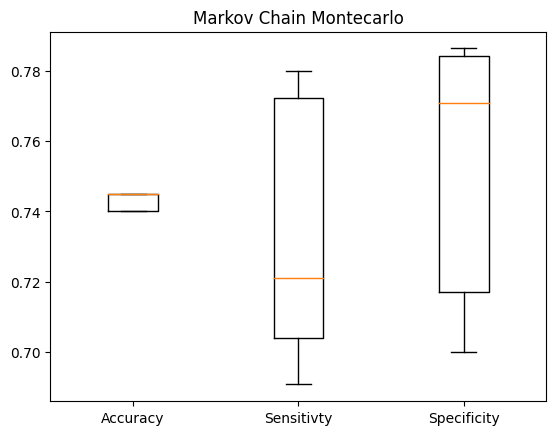

In [ ]:
plt.boxplot([accuracies,sensitivities,specificities])
plt.xticks([1, 2,3], ['Accuracy','Sensitivty','Specificity'])
plt.title("Markov Chain Montecarlo")
plt.show()

We can see that for all parameters we reach convergence.

Moreover, we can take some conclusions about the weight of each variable.
Obviously the Diabetes Pedigree Function has a high positive correlation with having the diabetes.
Also the number of pregnancies and the Body Mass Index have a significant high positive correlation with diabetes.
Skin thickness and insulin don't seem to be playng a role, but this could be because the value is missing for a lot of rows.

In [ ]:
df.head(1)

In [ ]:
accuracies

[0.725, 0.77, 0.715, 0.75, 0.745]

In [ ]:
import matplotlib.patches as mpatches



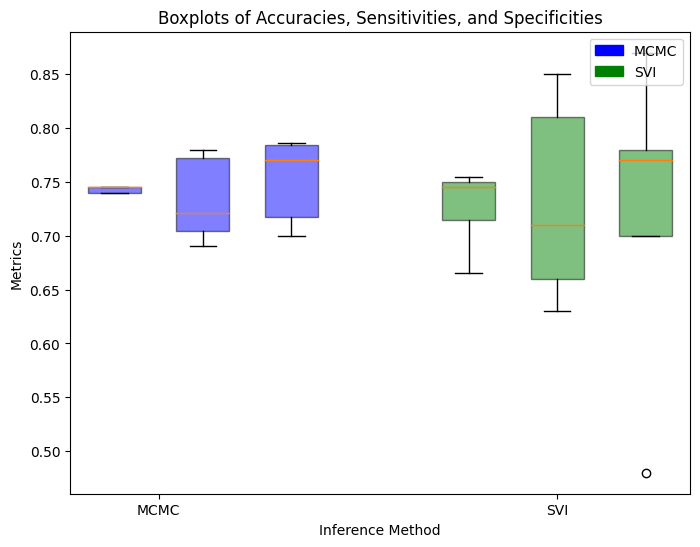

In [ ]:

# Data
accuracies_mcmc = accuracies
sensitivities_mcmc =sensitivities
specificities_mcmc = specificities

accuracies_svi = [0.745, 0.75, 0.665, 0.715, 0.755]
sensitivities_svi =[0.71, 0.63, 0.85, 0.66, 0.81]
specificities_svi = [0.78, 0.87, 0.48, 0.77, 0.7]

# Boxplot
plt.figure(figsize=(8, 6))

# MCMC data
bp_mcmc = plt.boxplot([accuracies_mcmc, sensitivities_mcmc, specificities_mcmc], positions=[1, 2, 3], widths=0.6, patch_artist=True)
for box in bp_mcmc['boxes']:
    box.set(facecolor='blue', alpha=0.5)

# SVI data
bp_svi = plt.boxplot([accuracies_svi, sensitivities_svi, specificities_svi], positions=[5, 6, 7], widths=0.6, patch_artist=True)
for box in bp_svi['boxes']:
    box.set(facecolor='green', alpha=0.5)

# Labels and legends
plt.xticks([1.5, 6], ['MCMC', 'SVI'])
plt.xlabel('Inference Method')
plt.ylabel('Metrics')
plt.title('Boxplots of Accuracies, Sensitivities, and Specificities')

# Legend for colors
blue_patch = mpatches.Patch(color='blue', label='MCMC')
green_patch = mpatches.Patch(color='green', label='SVI')
plt.legend(handles=[blue_patch, green_patch], loc='upper right')

plt.show()

